## Домашнее задание 1

### Вариант 5

**Выполнила** Шарыпина Даша, гр. 6382

### Задание 1

Выписать первый дифференциал для функций:

1. $f(X) = \mathrm{tr}\: (X^p), \quad X \in \mathbb{R}^{n \times n}$

Градиент:
$\nabla f(X) = p(X^{p-1})^T$

***Численная проверка градиента***

In [363]:
import numpy as np
from numpy.linalg import norm, matrix_power

# function
def f1(X, p):
    res = matrix_power(X, p)
    return np.trace(res)

# gradient 
def fgrad1(X, p):
    X_pow = matrix_power(X, p-1)
    res = p*X_pow.transpose()
    return res

def approx_grad1(f, X0, p):
    epsilon = 1e-4
    dim = X0.shape[0]
    grad = np.zeros((dim, dim))
    ei = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            ei[i][j] = epsilon
            grad[i][j] = (f1(X0 + ei, p) - f1(X0 - ei, p))/(2.*epsilon)
            ei[i][j] = 0.0
    return grad
    
def check_gradient1(f, gradf, X0, p):
    num_grad = approx_grad1(f, X0, p)
    theory_grad = gradf(X0, p)
    diff = norm(num_grad - theory_grad)/norm(num_grad + theory_grad)
    return diff

In [364]:
n = 5
X = np.random.randn(n, n)
p = 4
print('diff =', check_gradient1(f1, fgrad1, X, p))

diff = 7.250503031749267e-10


2. $f(x) = \frac{1}{2} \| xx^T - A\|^2_F, \quad x \in \mathbb{R}^n$

Градиент: $\nabla f(x) = 2xx^Tx - (A + A^T)x$

***Численная проверка градиента***

In [365]:
from scipy.optimize import check_grad

def f2(x, A):
    u = np.outer(x, x) - A
    res = 0.5*(norm(u, 'fro')**2)
    return res

def fgrad2(x, A):
    return 2.*x*norm(x)**2 - np.dot(A+A.T,x)

f = lambda m : f2(m, U)
fg = lambda m : fgrad2(m, U)

n = 5
U = np.random.randn(n, n)
x = np.random.randn(n,)

print('diff =', check_grad(f, fg, x))

diff = 8.336347393074003e-07


### Задание 2

1. Пользуясь библиотекой `NetworkX` задать графы вычислений для данных функций.

2. Реализовать необходимые `VJP` для элементарных функций в узлах вычислений.

3. Воспользоваться `make_function_and_gradient()` для получения функций, которые возвращают значения $f(x)$ и $ \nabla f(x)$ для произвольного аргумента $x$.

4. Сделать численную проверку градиента, а также сравнить с аналогичной функцией, полученной с помощью библиотеки `autograd`.

In [366]:
!pip install https://github.com/HIPS/autograd/archive/master.zip

     - 4.5MB 180.8MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-yfjytexu/wheels/1d/cf/71/e88cbaeb7af1fdd864ada20886075a6ffbc935d3b4eaf06a9a
Successfully built autograd


In [367]:
!pip install -U tensorly

Requirement already up-to-date: tensorly in /home/dasha/anaconda3/lib/python3.7/site-packages (0.4.3)


In [368]:
import autograd.numpy as anp

from autograd.scipy.misc import logsumexp
from autograd.scipy.signal import convolve

def softmax(x):    return anp.exp(x - logsumexp(x))
def softplus(x):   return anp.logaddexp(0., x)
def sigmoid(x):    return anp.reciprocal(anp.exp(softplus(-x)))
def flip(x):       return x[::-1]

In [369]:
def subassign(x, y, idx_dst, idx_src):
    assert(len(idx_dst) == len(idx_src))
    z = x.copy()
    z[idx_dst] = y[idx_src]
    return z

In [370]:
primitive_functions_dict = dict()

primitive_functions_dict['powexp'] = lambda x,y: np.power(x,y)
primitive_functions_dict['sin'] = lambda x: np.sin(x)
primitive_functions_dict['subassign'] = lambda x,y,idx_dst,idx_src: subassign(x, y, idx_dst, idx_src)
primitive_functions_dict['logsumexp'] = lambda x: logsumexp(x)
primitive_functions_dict['sigmoid'] = lambda x: sigmoid(x)

In [372]:
def vjp_subassign(vec, ans, x, y, idx_dst, idx_src):
    n = x.shape[0]
    m = y.shape[0]
    res_x = np.zeros(n)
    res_y = np.zeros(m)
    idx_x = np.array(range(0, n))
    res_idx = np.array(list(set(idx_x) - set(idx_dst)))
    res_x[res_idx] = vec[res_idx]
    res_y[idx_src] = vec[idx_dst]
    return [res_x, res_y]

In [373]:
vjps_dict = dict()

vjps_dict['sin'] = lambda vec, ans, x: [vec*np.cos(x)]
vjps_dict['powexp'] = lambda vec, ans, x, p: [vec*p*np.power(x,p-1), vec*np.log(x)*ans]
vjps_dict['sigmoid'] = lambda vec, ans, x: [vec*ans*(1-ans)]
vjps_dict['logsumexp'] = lambda vec, ans, x: [vec*np.exp(x)/sum(np.exp(x))]
vjps_dict['subassign'] = lambda vec, ans, x, y, idx_dst, idx_src: vjp_subassign(vec, ans, x, y, idx_dst, idx_src)

In [374]:
def make_function_and_gradient(computational_graph):
    
    nodes_sorted = list(nx.topological_sort(computational_graph))
    end_node = nodes_sorted[-1]
    
    def function(x):
        graph = computational_graph.copy()
        forward_pass(x, graph, nodes_sorted)
        f_x = graph.node[end_node]['value']
        return f_x
    
    def gradient(x):
        graph = computational_graph.copy()
        forward_pass(x, graph, nodes_sorted)
        g_x = backward_pass(graph, nodes_sorted)
        return g_x
    
    return function, gradient

**Прямой проход**

In [375]:
def forward_pass(x, graph, nodes_sorted):
           
    for node in nodes_sorted:
        func = graph.nodes[node]['function']
        parents = graph.nodes[node]['parents']
        args = []
        for p in parents:
            args.append(graph.nodes[p]['value'])
        if 'params' in graph.nodes[node]:
            args = args + [*graph.nodes[node]['params']]
        if len(args) > 0:
            graph.nodes[node]['value'] = primitive_functions_dict[func](*args)
        else:
            graph.nodes[node]['value'] = x
            

**Обратный проход**

In [376]:
def add_jacs(prev_jac, jac):
    if prev_jac is None:
        return jac
    else:
        return prev_jac + jac

def backward_pass(graph, nodes_sorted):
    
    nodes_sorted_backward = nodes_sorted[::-1]
    end_node = nodes_sorted_backward[0]
    jacs = {end_node: 1.0}
    
    for node in nodes_sorted_backward:
        func = graph.nodes[node]['function']
        value = graph.nodes[node]['value']
        parents = graph.nodes[node]['parents']        
        jac = jacs.pop(node)        
        args = []
        for p in parents:
            args.append(graph.nodes[p]['value'])
        if 'params' in graph.nodes[node]:
            args = args + [*graph.nodes[node]['params']]           
        if len(args) > 0:
            parent_jacs = vjps_dict[func](jac, value, *args)
        for i in range(len(parents)): 
            p = parents[i]
            jacs.update({p: add_jacs(jacs.get(p), parent_jacs[i])})           
    return jac


_________________________________________________

1. `function_5`

Определение функции:

In [378]:
idx1 = np.array([2,4,5])
idx2 = np.array([0,1,3])

def function_5(x):
    u = sigmoid(x)
    v = anp.sin(x)
    w = anp.power(u,v)
    w[idx1] = x[idx2]
    return logsumexp(w)

Зададим граф вычислений для функции:

In [379]:
import networkx as nx

G = nx.DiGraph()
nodes = range(0, 6)
G.add_nodes_from(nodes)

attrs = {0: {'function': None, 'value': None, 'parents': []}, 
         1: {'function': 'sigmoid', 'value': None, 'parents': [0]},
         2: {'function': 'sin', 'value': None, 'parents': [0]}, 
         3: {'function': 'powexp', 'value': None, 'parents': [1, 2]}, 
         4: {'function': 'subassign', 'value': None, 'parents': [3, 0], 'params': [idx1, idx2]},
         5: {'function': 'logsumexp', 'value': None, 'parents': [4]}}
nx.set_node_attributes(G, attrs)

G.add_edges_from([(0,1),(0,2),(1,3),(2,3),(3,4),(0, 4),(4,5)])

Визуализация:

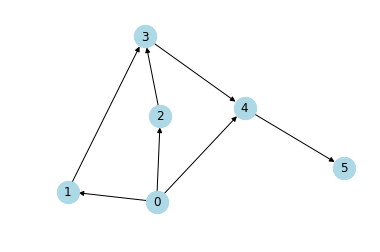

In [266]:
import matplotlib as mpl
import matplotlib.pyplot as plt
nx.draw_networkx(G, node_size = 500, node_color = 'lightblue')
plt.axis('off')
plt.show()

Получение функций, которые вычисляют $f(x)$ и $\nabla f(x)$

In [380]:
function, gradient = make_function_and_gradient(G)

Проверка корректности вычсления $f(x)$

In [381]:
dim = 6
x = np.random.randn(dim,)

f_true = function_5(x)
f = function(x)

print(f_true)
print(f)
print('Difference:', np.abs(f_true - f))

2.8654494342312984
2.8654494342312984
Difference: 0.0


Проверка корректности вычисления $\nabla f(x)$.
т.к. `autograd` не поддерживает `subassign`, будем использовать численную проверку `check_grad`

In [382]:
from scipy.optimize import check_grad
difference = check_grad(function, gradient, x)
print("diff = ", difference)

diff =  1.9372831477211464e-08


Таким образом, градиент вычислен верно.

___________________________________________________________________

2. `function_12`

Определение функции:

In [384]:
idx_1 = [2,1,0]
idx_2 = [0,1,2]

def function_12(x):
    u = softplus(x)
    v = anp.cumsum(u)
    u[idx_1] = v[idx_2]
    return anp.inner(u,v)

Добавим в `primitive_function_dict` необходимые функции:

In [385]:
primitive_functions_dict['softplus'] = lambda x: softplus(x)
primitive_functions_dict['inner'] = lambda x,y: np.inner(x,y)
primitive_functions_dict['cumsum'] = lambda x: np.cumsum(x)

Добавим в `vjps_dict` необходимые `vjp`:

In [387]:
vjps_dict['inner'] = lambda vec, ans, x, y: [vec*y, vec*x]
vjps_dict['cumsum'] = lambda vec, ans, x: [np.flipud(np.cumsum(np.flipud(vec)))]
vjps_dict['softplus'] = lambda vec, ans, x: [vec*sigmoid(x)]

Зададим граф вычислений:

In [388]:
G = nx.DiGraph()
nodes = range(0, 5)
G.add_nodes_from(nodes)

attrs = {0: {'function': None, 'value': None, 'parents': []}, 
         1: {'function': 'softplus', 'value': None, 'parents': [0]},
         2: {'function': 'cumsum', 'value': None, 'parents': [1]}, 
         3: {'function': 'subassign', 'value': None, 'parents': [1, 2], 'params': [idx_1, idx_2]}, 
         4: {'function': 'inner', 'value': None, 'parents': [2, 3]}}
nx.set_node_attributes(G, attrs)

G.add_edges_from([(0,1),(1,2),(1,3),(2,3),(2,4),(3, 4)])

In [389]:
function, gradient = make_function_and_gradient(G)

In [390]:
dim = 6
x = np.random.randn(dim,)

f_true = function_12(x)
f = function(x)

print(f_true)
print(f)
print('Difference:', np.abs(f_true - f))

19.2014030018048
19.2014030018048
Difference: 0.0


Проверка корректности вычисления $\nabla f(x)$
т.к. `autograd` не поддержвает `subassign`, будем использовать численное приближение градиента `check_grad`

In [391]:
from scipy.optimize import check_grad
difference = check_grad(function, gradient, x)
print(difference)

2.702147165494609e-07


Таким образом, градиент вычислен верно.

### Задание 3
Реализовать вычисление градиента функции `function_with_conv()` из
`automatic_differentiation_example.ipynb` используя библиотеку `autograd`. Так как функция свертки `convolve(a,b, mode='same')` не реализована в autograd, необходимо представить функцию `function_with_conv()` как композицию 3-х отображений: $f = f_2 \circ \mathrm{convolve} \circ f_1$. Градиент функции $f$ можно получить реализовав `VJP` для свертки и использовав `autograd` для нахождения
производных $f_2$ и $f_1$. Сделать численную проверку градиента, чтобы убедиться в корректности реализации.

Исходная функция `function_with_conv()`:

In [313]:
def function_with_conv(x):
    a = flip(x)
    b = anp.sin(x)
    c = a/b
    
    d = np.convolve(c, np.array([1,-2,1]), mode='same')
    
    e = 1./softmax(d)
    return anp.inner(e,e)

Представим $f(x)$ в виде $f(x) = f_2 \circ \mathrm{convolve} \circ f_1$.

Определелим соответствующие функции:

In [351]:
def f1(x):
    a = flip(x)
    b = anp.sin(x)
    return a / b

def f2(z):
    e = 1./softmax(z)
    return anp.inner(e, e)

def conv(y):
    return np.convolve(y, np.array([1, -2, 1]), mode='same')

Определим `VJP` для `conv`:

Матрица Якоби.

$\mathrm{convolve}$ можно представить в виде матричного произведения, если один из аргументов представить в виде матрицы Toeplitz

В данном случае имеем: 

\begin{equation*}
    \mathrm{convolve}(x, (1, -2, 1)) =
        \begin{pmatrix}
            x_1 & 0 & 0\\
            x_2 & x_1 & 0\\
            x_3 & x_2 & x_1\\
            \vdots & x_3 & \vdots\\
            x_{n-1} & \vdots & \vdots \\
            x_{n} & x_{n-1} & x_{n-2}\\
            0 & x_n &  x_{n-1}\\
            0 & 0 & x_n\\
        \end{pmatrix}
        \cdot
        \begin{pmatrix}
            1\\
            -2\\
            1
        \end{pmatrix}
\end{equation*}

Размерность $x$: $n$.
Размерность $x$ в виде матрицы Toeplitz: $(n + 2) \times 3$.

В таком случае матрица Якоби имеет вид:

\begin{equation*}
        J =
        \begin{pmatrix}
            1 & 0 & \dots & 0\\
            -2 & 1 & \dots & 0\\
            1 & -2 & \dots& 0\\
            \vdots & 1 & \dots & 0\\
            0 & \vdots & \vdots & 0 \\
            0 & 0 & \dots& 1\\
            0 & 0 &  \dots & -2\\
            0 & 0 & \dots & 1\\
        \end{pmatrix}
\end{equation*}

Размерность матрицы Якоби: $(n+2) \times n$

т.к. используется `mode = 'same'`, то первая и последняя строки матрицы не участвуют в вычислениях. И размерность получается $n \times n$

In [352]:
def vjp_conv(v, x):
    n = len(x)
    res = np.zeros(n)
    for i in range(1, n - 1):
        res[i] = v[i-1] + (-2) * v[i] + v[i+1]
    res[0] = (-2) * v[0] + v[1]
    res[n-1] = v[n-2] + (-2) * v[n-1]
    return res

$y = f_1(x)$

$z = \mathrm{conv}(y)$

$f = f_2(z)$

$(\nabla f)^T(x) = J_{f_2}(z)J_{\mathrm{conv}}(y)J_{f_1}(x)$

In [356]:
from autograd import jacobian, grad

def fgrad(x):
    J_f1 = jacobian(f1)(x)
    J_f2 = jacobian(f2)(conv(f1(x)))
    vjp = vjp_conv(J_f2, f1(x))
    res = np.dot(vjp, J_f1)
    return res

In [362]:
def approx_grad(f, x0):
    epsilon = 1e-5
    dim = len(x0)
    grad = np.zeros((dim,)).T
    ei   = np.zeros((dim,)).T
    for k in range(dim):
        ei[k] = epsilon
        grad[k] = (f(x0 + ei) - f(x0 - ei))/(2.*epsilon)
        ei[k] = 0.0
    return grad

def check_gradient(f, gradf, x0):
    num_grad = approx_grad(f, x0);
    anal_grad = gradf(x0);
    diff = norm(num_grad - anal_grad)/norm(num_grad + anal_grad)
    return diff

dim = 6
x = np.random.randn(dim,)
print("diff = ", check_gradient(function_with_conv, fgrad, x))

diff =  2.1916440583696234e-08


Таким образом, численная проверка градиента показывает, что градиент вычислен верно.

### Задание 5
Найти решение задачи оптимизации $\min_{x \in S} f(x)$, где множество допустимых решений $S \subset\mathbb{R}^2$ задано системой неравенств, а целевая функция является линейной. Визуализировать $S$ на основе примера из описания `scipy.spatial.HalfspaceIntersection`.

$$f(x) = -3x_1 - 2x_2$$

\begin{equation*}
 \begin{cases}
   x_1 + x_2 \leq 6\\
   x_1 - 2x_2 \leq 4\\
   x_1 \geq 3\\
   x_2 \geq 0
 \end{cases}
\end{equation*}

Визуализация $S$:

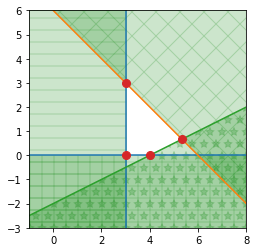

In [3]:
from scipy.spatial import HalfspaceIntersection
from scipy.optimize import linprog
from matplotlib.patches import Circle
import numpy as np

halfspaces = np.array([[-1, 0., 3.],
                       [0., -1., 0.],
                       [1., 1., -6.],
                       [1., -2., -4.]])

norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1),
    (halfspaces.shape[0], 1))
c = np.zeros((halfspaces.shape[1],))
c[-1] = -1
A = np.hstack((halfspaces[:, :-1], norm_vector))
b = - halfspaces[:, -1:]
res = linprog(c, A_ub=A, b_ub=b)
x = res.x[:-1]

feasible_point = np.array(x)
hs = HalfspaceIntersection(halfspaces, feasible_point)

# Plot halfspaces as filled regions and intersection points:

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot('111', aspect='equal')
xlim, ylim = (-1, 8), (-3, 6)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
x = np.linspace(-1, 8, 100)
symbols = ['-', '+', 'x', '*']
signs = [0, 0, -1, 0]
fmt = {"color": "green", "edgecolor": "b", "alpha": 0.2}
for h, sym, sign in zip(halfspaces, symbols, signs):
    hlist = h.tolist()
    fmt["hatch"] = sym
    if h[1] == 0:
        ax.axvline(-h[2]/h[0], label='{}x+{}y+{}<=0'.format(*hlist))
        xi = np.linspace(xlim[sign], -h[2]/h[0], 100)
        ax.fill_between(xi, ylim[0], ylim[1], **fmt)
    else:
        ax.plot(x, (-h[2]-h[0]*x)/h[1], label='{}x+{}y+{}<=0'.format(*hlist))
        ax.fill_between(x, (-h[2]-h[0]*x)/h[1], ylim[sign], **fmt)
x, y = zip(*hs.intersections)
#plt.legend(bbox_to_anchor=(2, 1.0))
ax.plot(x, y, 'o', markersize=8)

На рисунке выше область $S$ представлена белым четырехугольником.

Градиент функции: 
\begin{equation*}
    \nabla f(x) = 
    \begin{pmatrix}
        -3\\
        -2
    \end{pmatrix}
\end{equation*}
Чтобы найти минимум функции, нужно двигаться в направлении антиградиента.
Так как целевая функция является линейной, а $S$ представляет собой многоугольник, то решение будет находится в вершине многоугольника.
Минимум функции будет в самой правой вершине четырехугольника.

Получим вершины многоугольника:

In [14]:
print(hs.intersections)

[[3.         3.        ]
 [3.         0.        ]
 [5.33333333 0.66666667]
 [4.         0.        ]]


Таким образом, $\mathrm{min}_S f(x) = -17\frac{1}{3}$ функция достигает при $x_1 = 5\frac{1}{3}, x_2 = \frac{2}{3}$